In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gpytorch
import torch.nn as nn

# ------------------ Load and Preprocess Data ------------------
# Normalize the data (zero mean, unit variance over the 10x10x100 subset)
data_np = np.load('spatial_temporal_data.npy')
data = data_np[50:60, 100:110, :100]
data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std  # (10, 10, 100)

H, W, T = data.shape
x_grid, y_grid = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
locations = np.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

# ------------------ Fixed training locations (for fair comparison) ------------------
train_locs = np.array([
    (0, 0), (0, 4), (0, 9),
    (2, 2), (2, 7),
    (4, 0), (4, 5), (4, 9),
    (5, 7),
    (6, 2), (6, 7),
    (7, 0), (7, 5),
    (9, 4), (9, 9),
], dtype=int)

print("Trained spatial locations (x, y):", [tuple(loc) for loc in train_locs])

train_x_space = torch.tensor(train_locs, dtype=torch.float32)           # (15, 2)
train_x_time = torch.arange(T, dtype=torch.float32).unsqueeze(1)       # (100, 1)

train_inputs = []
train_outputs = []

for i, loc in enumerate(train_locs):
    x_idx, y_idx = loc
    ts = data[x_idx, y_idx]  # (100,)
    loc_tensor = train_x_space[i].repeat(T, 1)  # (100, 2)
    train_inputs.append(torch.cat([loc_tensor, train_x_time], dim=1))  # (100, 3)
    train_outputs.append(torch.tensor(ts, dtype=torch.float32))        # (100,)

train_x = torch.cat(train_inputs, dim=0)   # (15*100, 3)
train_y = torch.cat(train_outputs, dim=0)  # (15*100,)

# Optionally normalize spatial/time inputs a bit (helps DKL training)
# Here simple scaling to [0,1] range for each dimension.
train_x_norm = train_x.clone()
train_x_norm[:, 0] /= (H - 1)
train_x_norm[:, 1] /= (W - 1)
train_x_norm[:, 2] /= (T - 1)

# ------------------ DKL Spatial Feature Extractor ------------------
class SpatialFeatureExtractor(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=32, out_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x_space):
        return self.net(x_space)



# ------------------ GP Model with DKL in Space + Spectral Mixture in Time ------------------
class SpatioTemporalDKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Spatial DKL: feature extractor + base RBF kernel in feature space
        self.feature_extractor = SpatialFeatureExtractor(in_dim=2, hidden_dim=32, out_dim=8)
        self.covar_module_space = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        # Temporal kernel: Spectral Mixture on time only
        # We'll feed it (N, 1) time inputs directly.
        self.covar_module_time = gpytorch.kernels.SpectralMixtureKernel(
            num_mixtures=4
        )
        # Initialize from time + targets
        self.covar_module_time.initialize_from_data(
            train_x[:, 2:3],  # time dimension only
            train_y
        )

    def forward(self, x):
        """
        x is the *normalized* input of shape (N, 3) = (x, y, t).
        We'll:
        - take x_space = x[..., :2]
        - take x_time  = x[..., 2:3]
        - pass x_space through feature extractor
        - apply RBF in feature space for spatial covariance
        - apply Spectral Mixture on time for temporal covariance
        - combine by elementwise product
        """
        mean_x = self.mean_module(x)

        x_space = x[..., :2]   # (N, 2)
        x_time  = x[..., 2:3]  # (N, 1)

        # Deep spatial features
        z = self.feature_extractor(x_space)    # (N, d)
        K_space = self.covar_module_space(z)   # (N, N)

        # Temporal kernel on time only
        K_time  = self.covar_module_time(x_time)  # (N, N)

        covar_x = K_space * K_time
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ------------------ Train GP ------------------
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpatioTemporalDKLModel(train_x_norm, train_y, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(100):
    optimizer.zero_grad()
    output = model(train_x_norm)
    loss = -mll(output, train_y)
    loss.backward()
    # if i % 10 == 0:
    #     print(f"Iter {i:3d} - Loss: {loss.item():.3f}")
    optimizer.step()

# ------------------ Predict on Full Grid ------------------
test_inputs = []
for i in range(H):
    for j in range(W):
        spatial = torch.tensor([i, j], dtype=torch.float32).repeat(T, 1)  # (T, 2)
        temporal = train_x_time                                           # (T, 1)
        combined = torch.cat([spatial, temporal], dim=1)                  # (T, 3)
        test_inputs.append(combined)

test_x = torch.cat(test_inputs, dim=0)  # (H*W*T, 3)

# Normalize test_x the same way as train_x
test_x_norm = test_x.clone()
test_x_norm[:, 0] /= (H - 1)
test_x_norm[:, 1] /= (W - 1)
test_x_norm[:, 2] /= (T - 1)

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(test_x_norm))
    pred_mean = pred_dist.mean.reshape(H, W, T)


Trained spatial locations (x, y): [(0, 0), (0, 4), (0, 9), (2, 2), (2, 7), (4, 0), (4, 5), (4, 9), (5, 7), (6, 2), (6, 7), (7, 0), (7, 5), (9, 4), (9, 9)]


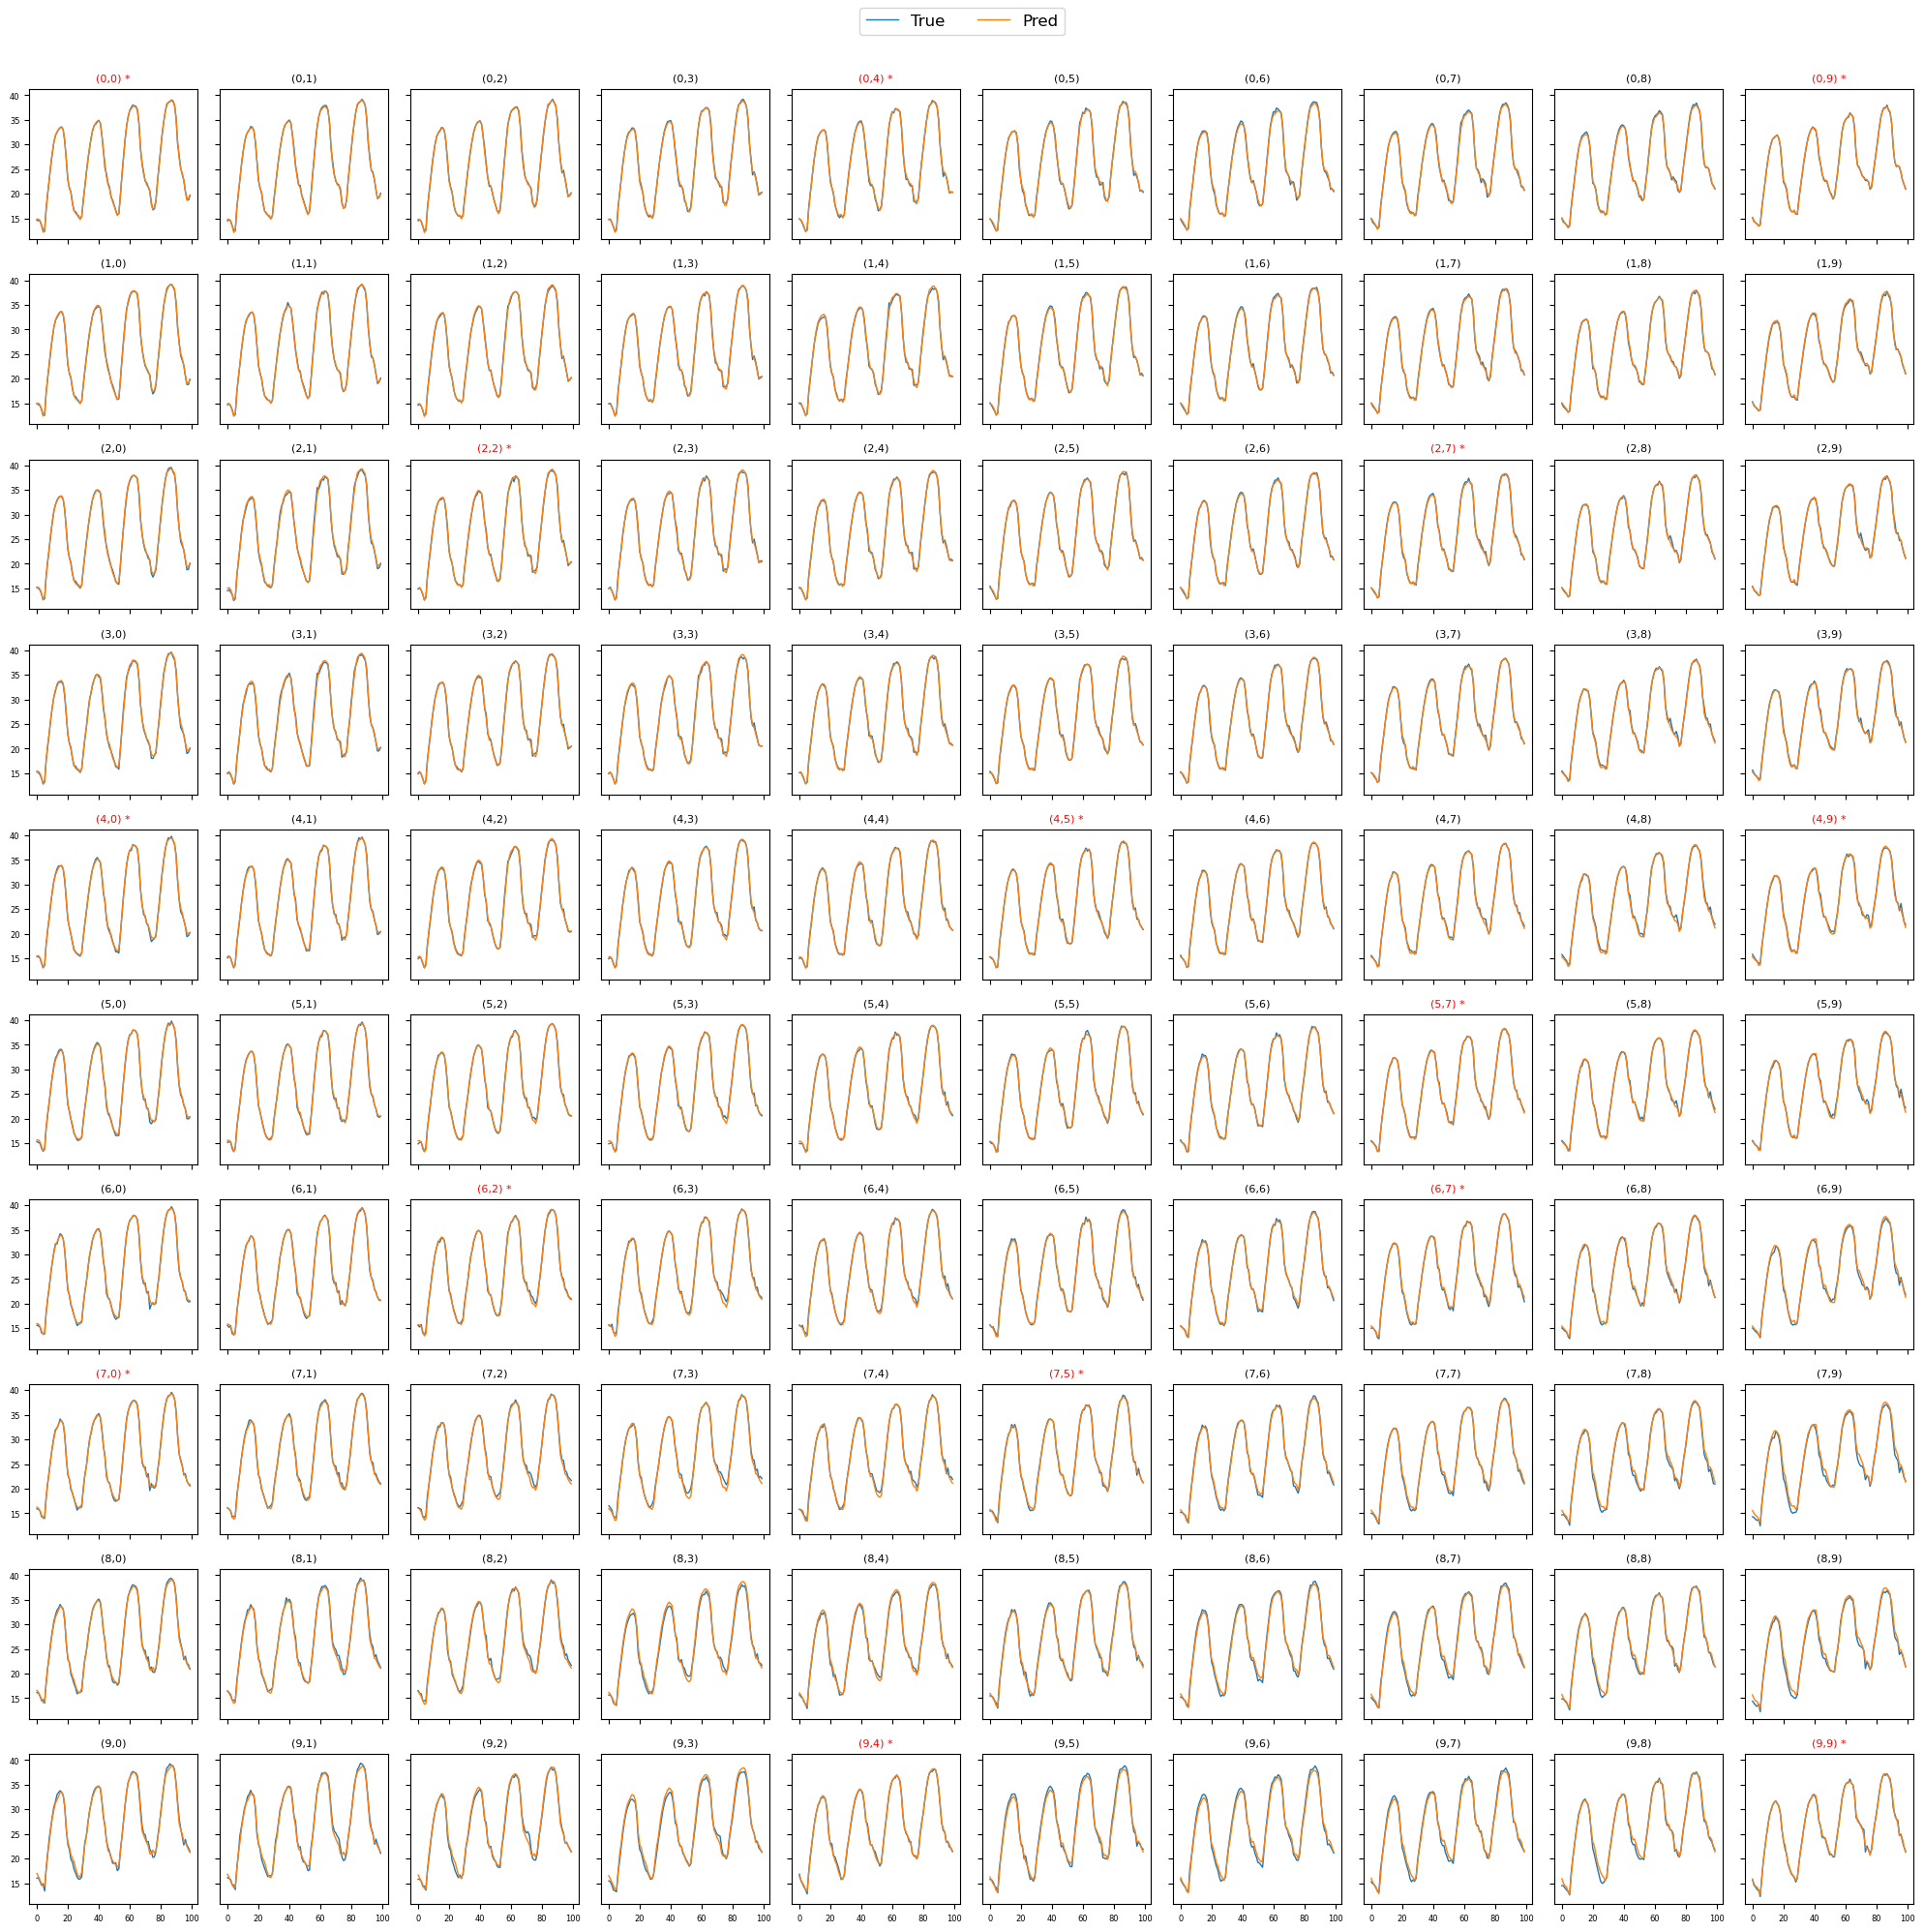

In [12]:
# Time series comparison for all locations (denormalized)
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        true_ts = data[i, j, :] * data_std + data_mean
        pred_ts = pred_mean[i, j, :] * data_std + data_mean

        axs[i, j].plot(true_ts, label='True', linewidth=1)
        axs[i, j].plot(pred_ts.detach().cpu().numpy(), label='Pred', linewidth=1)

        is_train = (i, j) in train_locs_set
        title = f'({i},{j})' + (' *' if is_train else '')

        axs[i, j].set_title(
            title,
            fontsize=8,
            color='red' if is_train else 'black'
        )
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



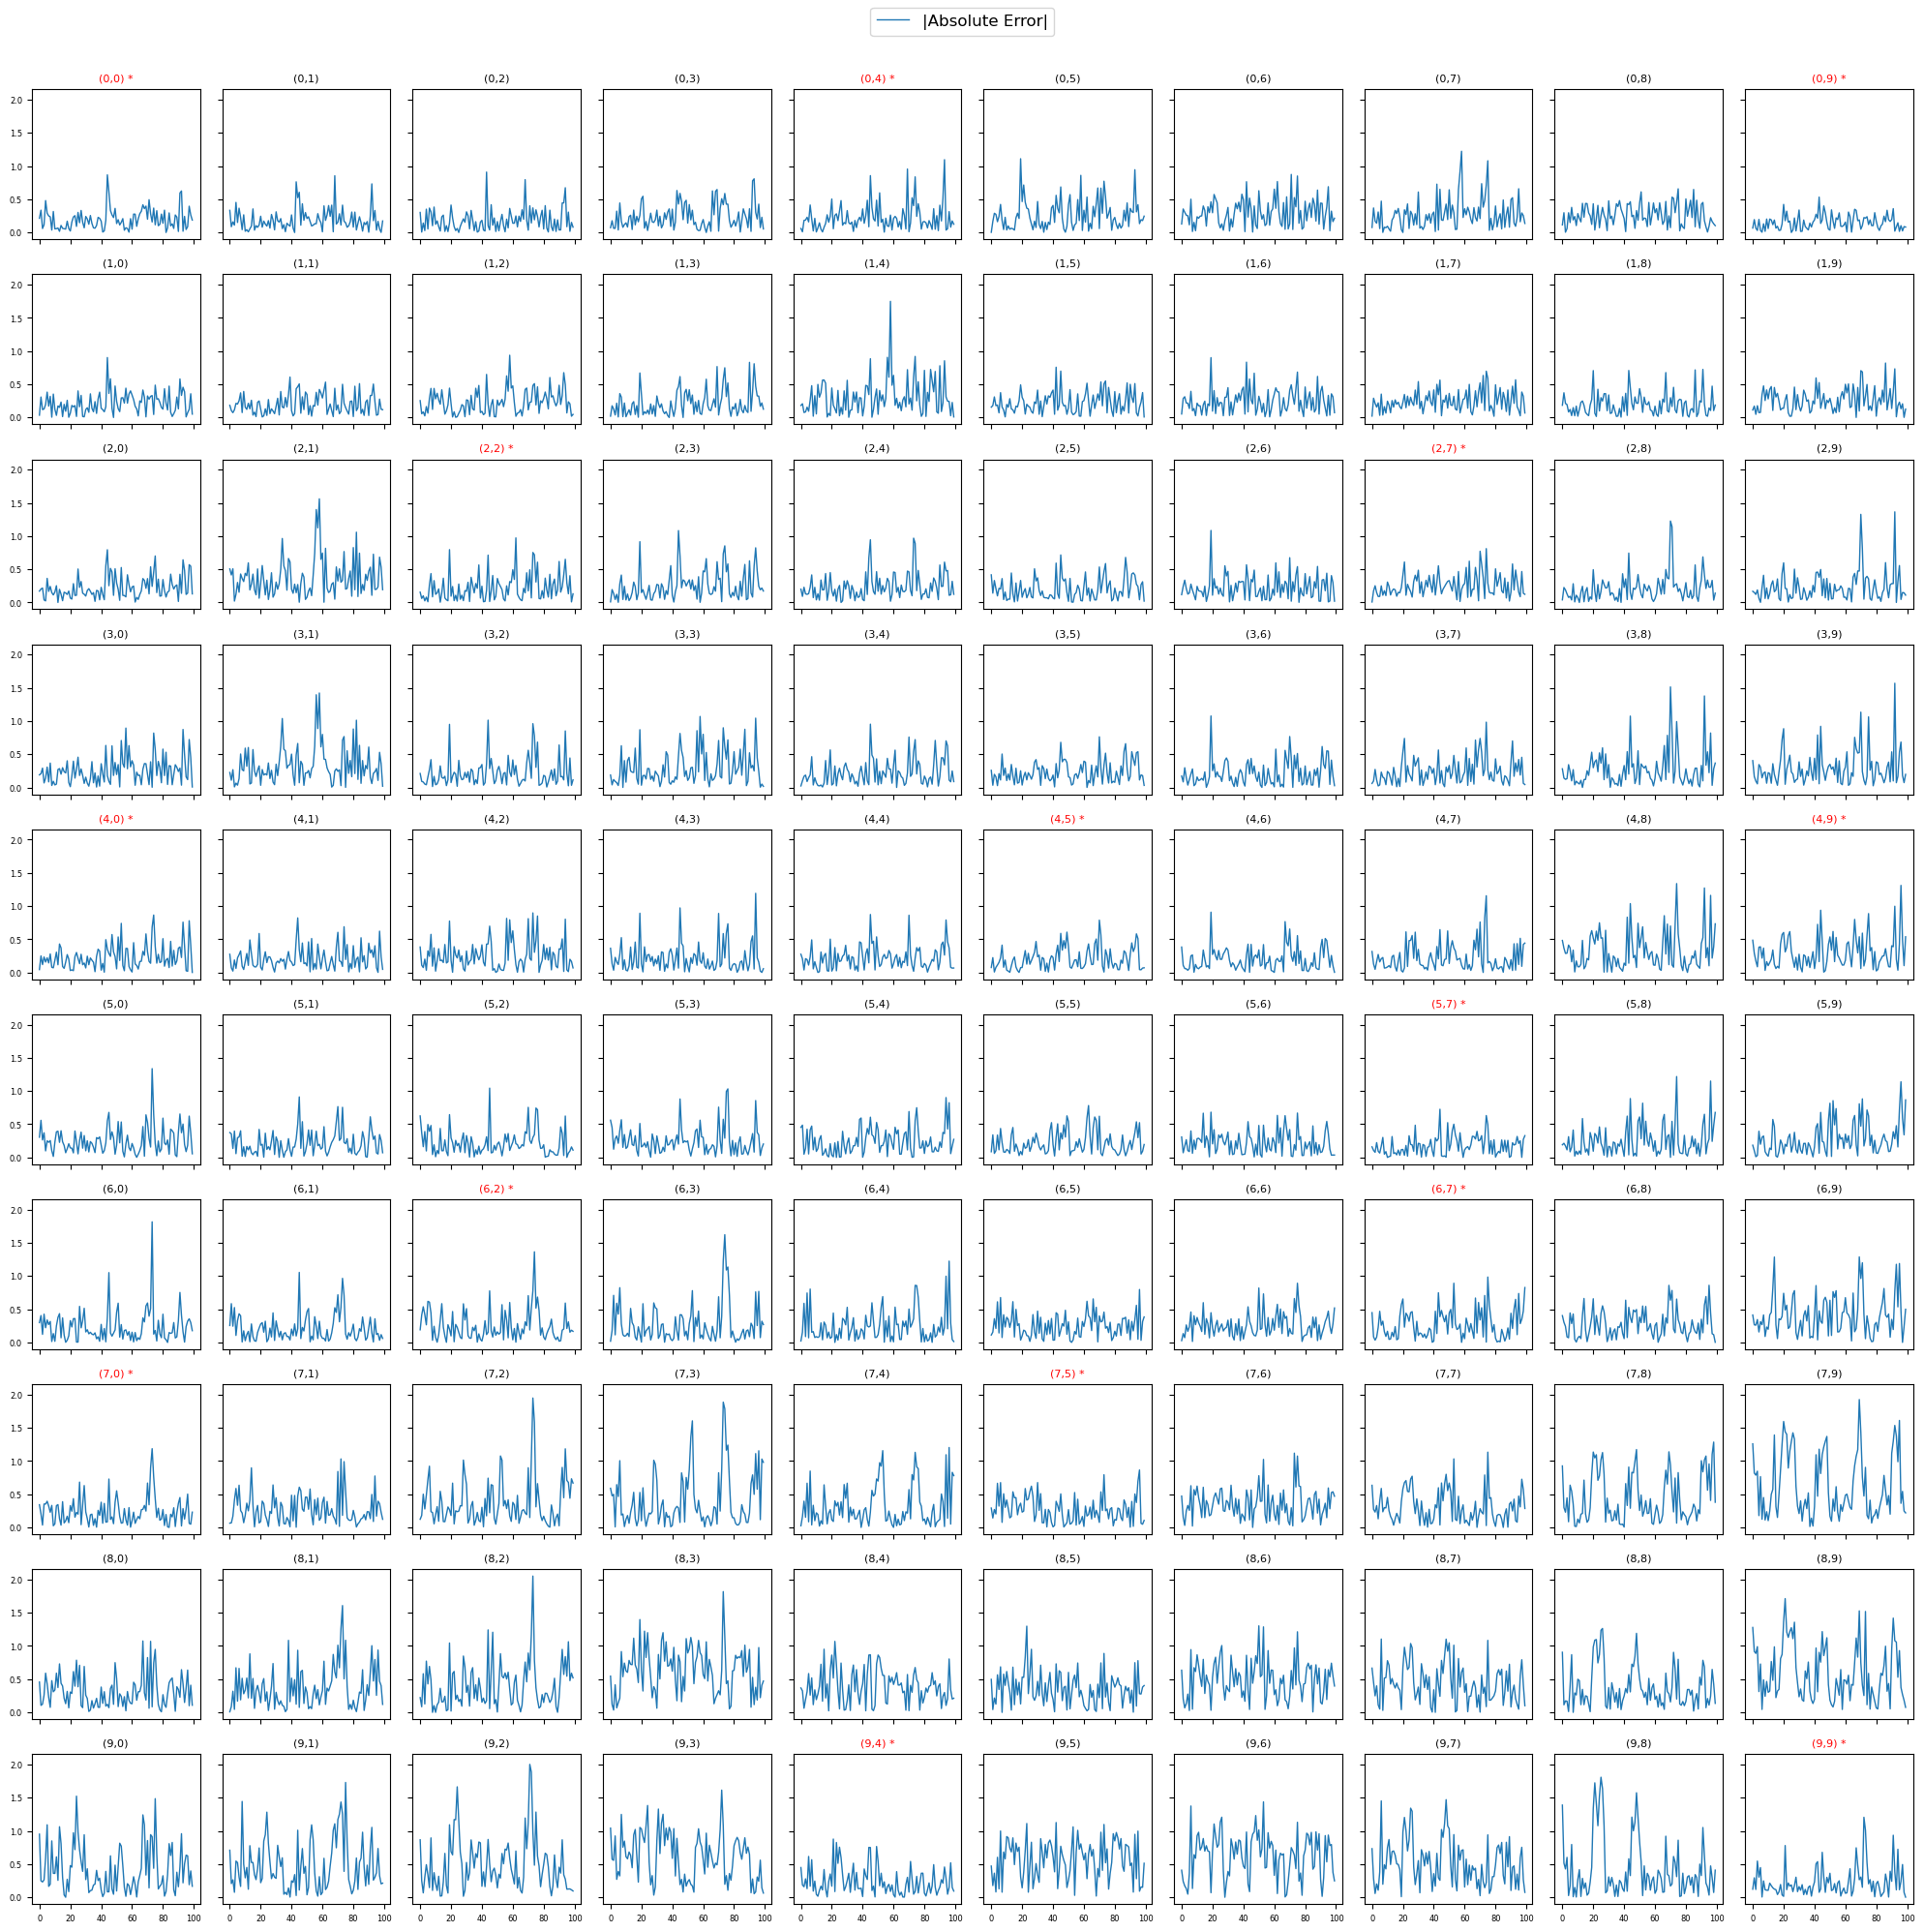

In [13]:
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Compute absolute error in normalized space, then scale to original units
        abs_err = torch.abs(
            pred_mean[i, j, :] - torch.tensor(data[i, j, :])
        ) * data_std
        abs_err = abs_err.detach().cpu().numpy()

        axs[i, j].plot(abs_err, label='|Error|', linewidth=1, color='tab:blue')

        is_train = (i, j) in train_locs_set
        title = f'({i},{j})' + (' *' if is_train else '')

        axs[i, j].set_title(
            title,
            fontsize=8,
            color='red' if is_train else 'black'
        )
        axs[i, j].tick_params(labelsize=6)

fig.legend(['|Absolute Error|'], loc='upper center', ncol=1, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Location (0,1): 0 points exceed 1.0
Location (5,9): 1 points exceed 1.0
Location (8,2): 6 points exceed 1.0


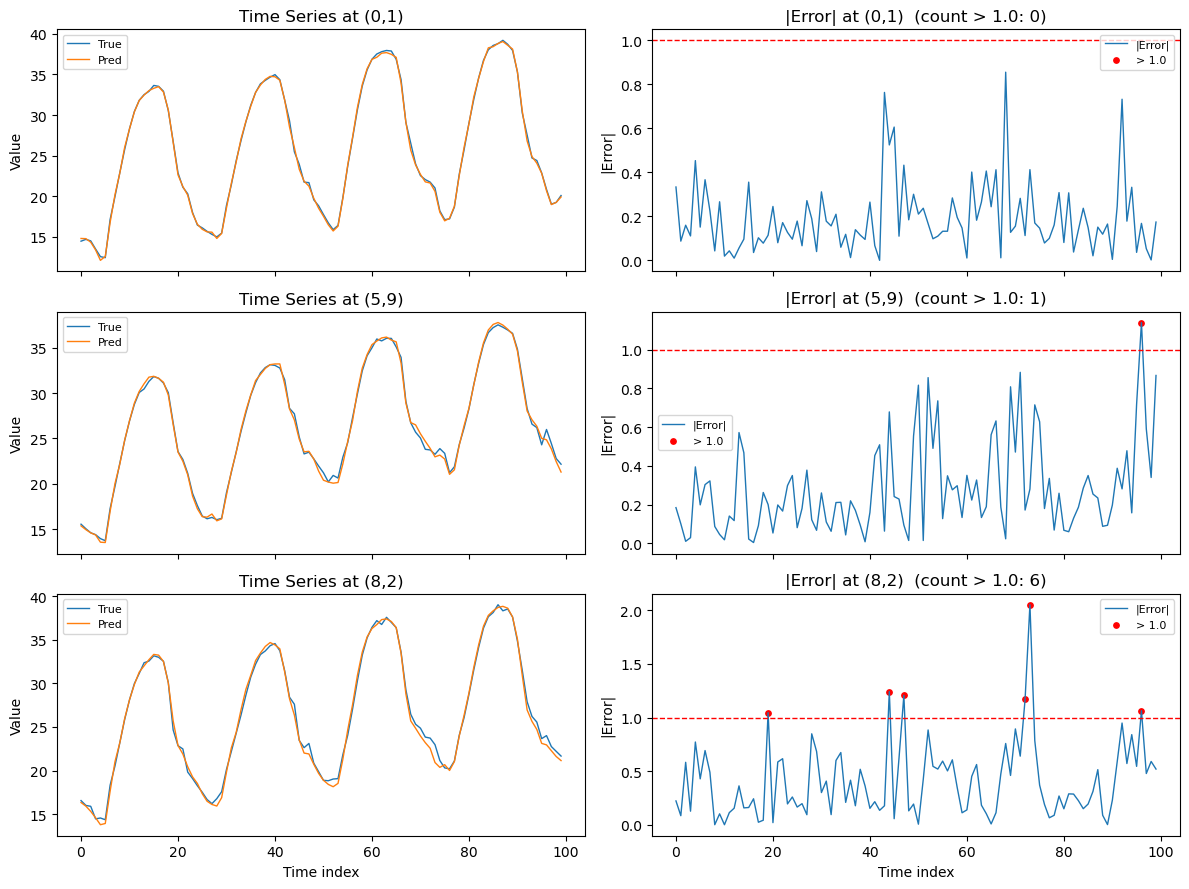

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Locations to inspect
locations = [(0, 1), (5, 9), (8, 2)]
threshold = 1.0

fig, axs = plt.subplots(len(locations), 2, figsize=(12, 3 * len(locations)), sharex=True)

for row, (i, j) in enumerate(locations):
    # ---- Denormalize true & predicted time series ----
    true_ts = data[i, j, :] * data_std + data_mean
    pred_ts = pred_mean[i, j, :].detach().cpu().numpy() * data_std + data_mean

    # ---- Absolute error (denormalized) ----
    abs_err = np.abs(pred_ts - true_ts)

    # ---- Count exceedances ----
    exceed_idx = abs_err > threshold
    num_exceed = np.sum(exceed_idx)

    print(f"Location ({i},{j}): {num_exceed} points exceed {threshold}")

    # ---- Plot true vs pred ----
    axs[row, 0].plot(true_ts, label="True", linewidth=1)
    axs[row, 0].plot(pred_ts, label="Pred", linewidth=1)
    axs[row, 0].set_title(f"Time Series at ({i},{j})")
    axs[row, 0].set_ylabel("Value")
    axs[row, 0].legend(fontsize=8)

    # ---- Plot absolute error ----
    axs[row, 1].plot(abs_err, label="|Error|", linewidth=1)
    axs[row, 1].axhline(threshold, color="red", linestyle="--", linewidth=1)

    # Mark exceedances
    axs[row, 1].scatter(
        np.where(exceed_idx)[0],
        abs_err[exceed_idx],
        color="red",
        s=15,
        label="> 1.0"
    )

    axs[row, 1].set_title(f"|Error| at ({i},{j})  (count > 1.0: {num_exceed})")
    axs[row, 1].set_ylabel("|Error|")
    axs[row, 1].legend(fontsize=8)

axs[-1, 0].set_xlabel("Time index")
axs[-1, 1].set_xlabel("Time index")

plt.tight_layout()
plt.show()
